#### Predicting import/export and exchange between Germany and France

# QRT ENS Data Challenge 2023
## Data Specs (Copied from Official)
- `X_train` and `X_test` both have $35$ columns that represent the same explanatory variables but over different time periods. 

- `X_train` and `Y_train` share the same column `ID` - each row corresponds to a unique ID associated wwith a day and a country. 

- The target of this challenge `TARGET` in `Y_train` corresponds to the price change for daily futures contracts of 24H electricity baseload. 

- **You will notice some columns have missing values**.

Input data sets comprise 35 columns:

ID: Unique row identifier, associated with a day (DAY_ID) and a country (COUNTRY),

DAY_ID: Day identifier - dates have been anonymized, but all data corresponding to a specific day is consistent,

COUNTRY: Country identifier - DE = Germany, FR = France,
and then contains daily commodity price variations,

GAS_RET: European gas,

COAL_RET: European coal,

CARBON_RET: Carbon emissions futures,

#### Weather measures (daily, in the country x)

x_TEMP: Temperature,

x_RAIN: Rainfall,

x_WIND: Wind,


#### Energy production measures (daily, in the country x)

x_GAS: Natural gas,

x_COAL: Hard coal,

x_HYDRO: Hydro reservoir,

x_NUCLEAR: Daily nuclear production,

x_SOLAR: Photovoltaic,

x_WINDPOW: Wind power,

x_LIGNITE: Lignite,

#### Electricity use metrics (daily, in the country x)

x_CONSUMPTON: Total electricity consumption,

x_RESIDUAL_LOAD: Electricity consumption after using all renewable energies,

x_NET_IMPORT: Imported electricity from Europe,

x_NET_EXPORT: Exported electricity to Europe,

DE_FR_EXCHANGE: Total daily electricity exchange between Germany and France,

FR_DE_EXCHANGE: Total daily electricity exchange between France and Germany.

Output data sets are composed of two columns:

ID: Unique row identifier - corresponding to the input identifiers,

TARGET: Daily price variation for futures of 24H electricity baseload.

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import itertools as it
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression as mir
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder as onehot
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.tsa.stattools import pacf
import xgboost as xgb
import lightgbm as lgb
from itertools import product
from scipy import signal
from scipy import stats
from statsmodels.tsa.deterministic import Fourier
from sklearn.model_selection import TimeSeriesSplit
from utils import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [57]:
df = pd.read_csv('x_train.csv').set_index('ID').sort_index()
y = pd.read_csv('y_train.csv').set_index('ID').sort_index()
true_test = pd.read_csv('x_test.csv').set_index('ID')

de = df[df['COUNTRY'] == 'DE']
y_de = y[y.index.isin(de.index)]

fr = df[df['COUNTRY'] == 'FR']
y_fr = y[y.index.isin(fr.index)]

full = df.append(true_test).sort_index()
full_de = full[full['COUNTRY'] == 'DE'].drop(['DAY_ID', 'COUNTRY'], axis=1)
full_fr = full[full['COUNTRY'] == 'FR'].drop(['DAY_ID', 'COUNTRY'], axis=1)

de_wind_gap = pd.read_csv('de_wind_reconstructed_gap.csv').set_index('ID').sort_index()
fr_wind_gap = pd.read_csv('fr_wind_reconstructed_gap.csv').set_index('ID').sort_index()
full_fr.loc[fr_wind_gap.index, 'FR_WIND'] = fr_wind_gap['0']
full_fr.loc[de_wind_gap.index, 'DE_WIND'] = de_wind_gap['0']

full_de_norm = full_de.copy()
full_de_norm = (full_de_norm - full_de_norm.mean()) / full_de_norm.std()

full_fr_norm = full_fr.copy()
full_fr_norm = (full_fr_norm - full_fr_norm.mean()) / full_fr_norm.std()

bx_train, bx_test, by_train, by_test = train_test_split(df, y, test_size=0.33, random_state=88)
df_numeric = df.drop(['DAY_ID', 'COUNTRY', 'FR_DE_EXCHANGE', 'FR_NET_EXPORT', 'DE_NET_EXPORT'], axis=1)
df_numeric = df_numeric.fillna(df_numeric.median(numeric_only=True))

In [58]:
full_fr[full_fr.index.isin(fr_wind_gap.index)]

,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1657,0.789367,2.023643,2.197203,-2.197203,1.105777,-1.780434,-1.105777,1.780434,1.624260,1.663172,-0.008884,0.133754,0.060703,1.299060,-0.078085,1.095300,-1.450159,-1.086241,0.470569,-0.189442,0.243512,0.639883,2.161360,NaN,NaN,-0.644922,-0.900284,NaN,NaN,0.682637,1.057258,1.224726
1658,1.021339,2.237380,2.495411,-2.495411,1.134751,-1.616863,-1.134751,1.616863,1.932549,1.919507,0.347985,0.296298,0.200141,2.586607,0.046322,1.087867,-1.442296,-1.194894,0.370722,-0.262677,0.477996,0.884387,2.392852,NaN,NaN,-0.666136,-0.921531,NaN,NaN,-4.269256,-0.770407,-2.868455
1659,0.621926,2.261159,1.743034,-1.743034,0.267362,-1.691992,-0.267362,1.691992,2.054023,2.063663,0.659524,0.696617,-0.615736,2.679881,0.202849,1.136006,-1.427140,-0.972609,-0.342873,-0.631142,0.413651,1.226444,2.475473,NaN,NaN,-0.857959,-1.021752,NaN,NaN,-0.429607,0.721945,-0.766894
1660,1.058364,2.335423,1.976357,-1.976357,-0.214021,-1.570298,0.214021,1.570298,2.426421,2.185752,0.968407,1.209990,0.842106,3.364177,0.219927,1.157400,-1.415586,-0.695635,-0.696637,-0.624432,0.579002,1.836831,2.537454,NaN,NaN,-0.949869,-1.021363,NaN,NaN,2.590490,1.186364,2.946484
1661,0.922049,2.333348,1.277670,-1.277670,-0.374810,-1.167448,0.374810,1.167448,2.711776,2.267040,0.940112,1.211683,-0.054381,3.755666,0.215484,1.155260,-1.401194,-0.468982,-0.808878,-0.588282,0.547426,1.838511,2.513394,NaN,NaN,-0.974743,-1.012982,NaN,NaN,2.363348,0.164690,1.253967
1662,1.759370,2.432090,1.130185,-1.130185,0.946258,-1.120062,-0.946258,1.120062,1.029457,2.083620,-0.094703,1.243060,0.213862,2.987544,-0.028099,1.155462,-1.237168,-0.478245,1.828750,0.661909,-0.036047,0.029680,2.343126,NaN,NaN,-0.235602,-0.674688,NaN,NaN,-0.296080,-0.399210,2.841211
1663,1.805389,2.178594,0.823826,-0.823826,1.299341,0.113097,-1.299341,-0.113097,1.002709,1.974587,-0.031204,1.184342,-0.679538,2.724560,-0.032631,1.045754,-1.367067,-1.067882,1.995841,2.388932,-0.372722,-0.034717,1.712034,NaN,NaN,-0.183009,-0.208566,NaN,NaN,2.976056,0.140961,4.575306
1664,1.851717,1.650085,0.770745,-0.770745,1.323036,0.308021,-1.323036,-0.308021,0.506032,1.905167,-0.250736,0.897297,-1.158224,2.620839,-0.088235,0.931180,-1.213075,-0.900257,2.591416,1.353553,-0.418173,-0.589277,1.432348,NaN,NaN,-0.011433,-0.482348,NaN,NaN,-0.896412,-1.087599,-3.967640
1665,1.605983,1.459767,-0.448453,0.448453,-0.244380,0.662073,0.244380,-0.662073,2.047218,1.587278,0.500876,0.931639,-0.787418,2.140750,0.197330,1.041784,-1.358709,-0.869714,0.110550,2.191060,0.537166,1.477422,1.048016,NaN,NaN,-0.694766,-0.254335,NaN,NaN,-0.539853,-0.133094,-0.173480


In [6]:
full_fr.count()

DAY_ID              1216
COUNTRY             1216
DE_CONSUMPTION      1216
FR_CONSUMPTION      1216
DE_FR_EXCHANGE      1182
FR_DE_EXCHANGE      1182
DE_NET_EXPORT       1045
FR_NET_EXPORT       1122
DE_NET_IMPORT       1045
FR_NET_IMPORT       1122
DE_GAS              1216
FR_GAS              1216
DE_COAL             1216
FR_COAL             1216
DE_HYDRO            1216
FR_HYDRO            1216
DE_NUCLEAR          1216
FR_NUCLEAR          1216
DE_SOLAR            1216
FR_SOLAR            1216
DE_WINDPOW          1216
FR_WINDPOW          1216
DE_LIGNITE          1216
DE_RESIDUAL_LOAD    1216
FR_RESIDUAL_LOAD    1216
DE_RAIN             1149
FR_RAIN             1149
DE_WIND             1149
FR_WIND             1149
DE_TEMP             1149
FR_TEMP             1149
GAS_RET             1216
COAL_RET            1216
CARBON_RET          1216
dtype: int64

In [90]:
full_cols = ['DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_GAS', 'FR_GAS', 'DE_COAL', 'FR_COAL', 'DE_HYDRO', 'FR_HYDRO',
       'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW',
       'FR_WINDPOW', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD',
       'DE_WIND', 'FR_WIND', 'GAS_RET', 'COAL_RET', 'CARBON_RET']

<Axes: xlabel='ID', ylabel='FR_CONSUMPTION'>

<Figure size 640x480 with 0 Axes>

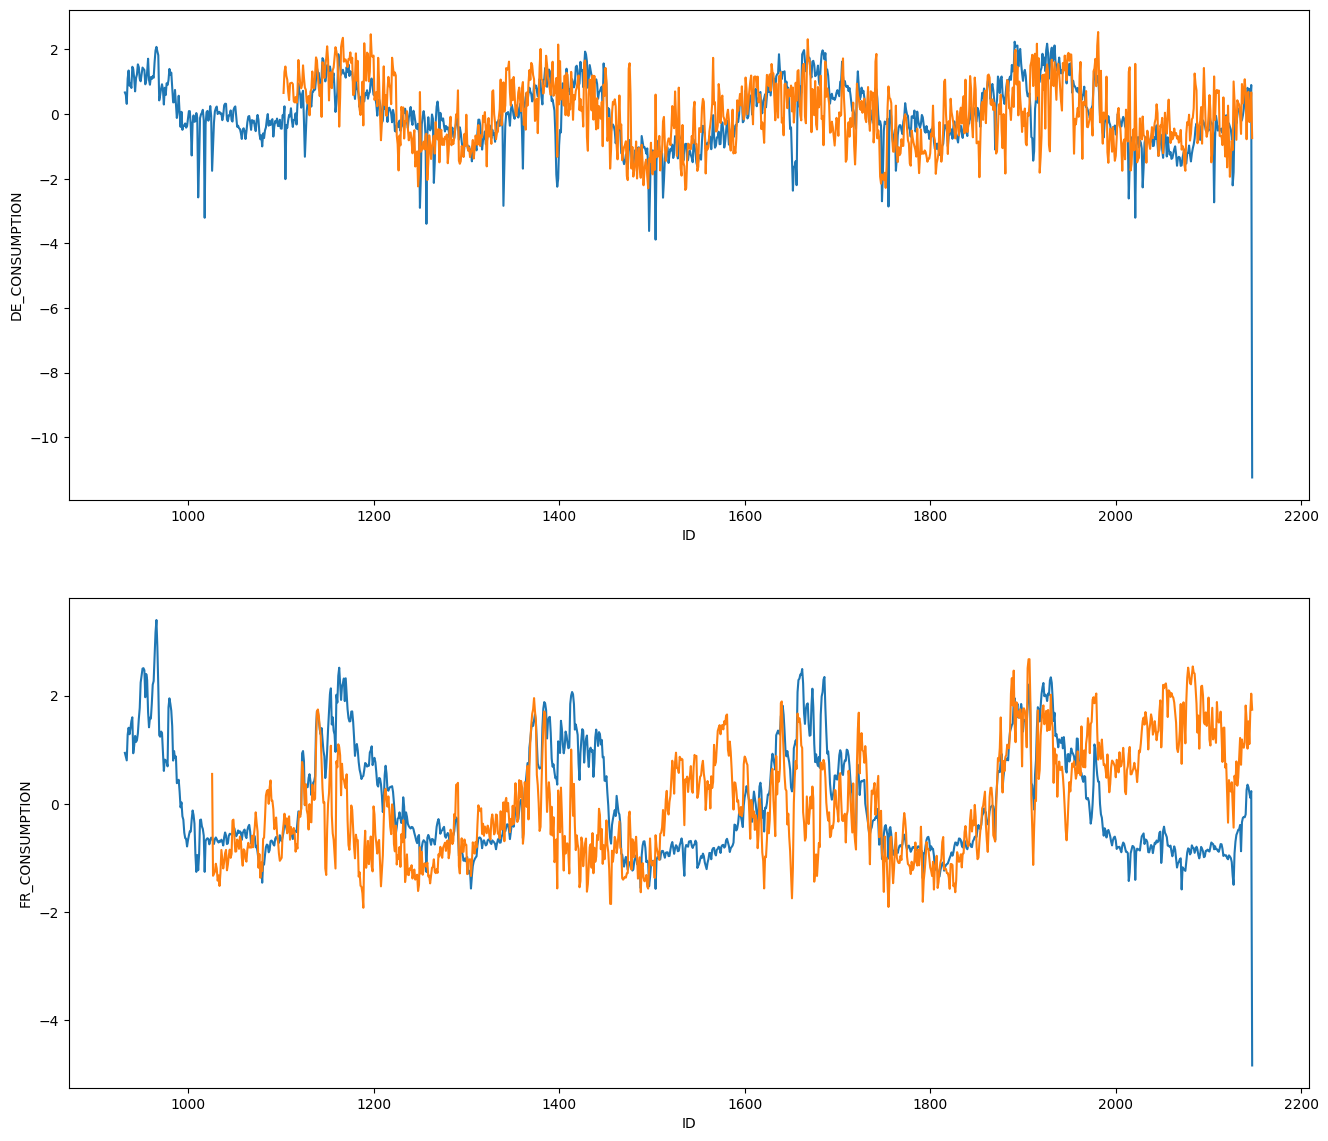

In [3]:
plt.figure()
fig, ax = plt.subplots(2, figsize=(16, 14))
sns.lineplot(x=full_fr_norm.index, y=full_fr_norm['DE_CONSUMPTION'], ax=ax[0])
sns.lineplot(x=full_fr_norm.index, y=full_fr_norm['DE_NET_EXPORT'], ax=ax[0])

sns.lineplot(x=full_fr_norm.index, y=full_fr_norm['FR_CONSUMPTION'], ax=ax[1])
sns.lineplot(x=full_fr_norm.index, y=full_fr_norm['FR_NET_IMPORT'], ax=ax[1])

<Figure size 640x480 with 0 Axes>

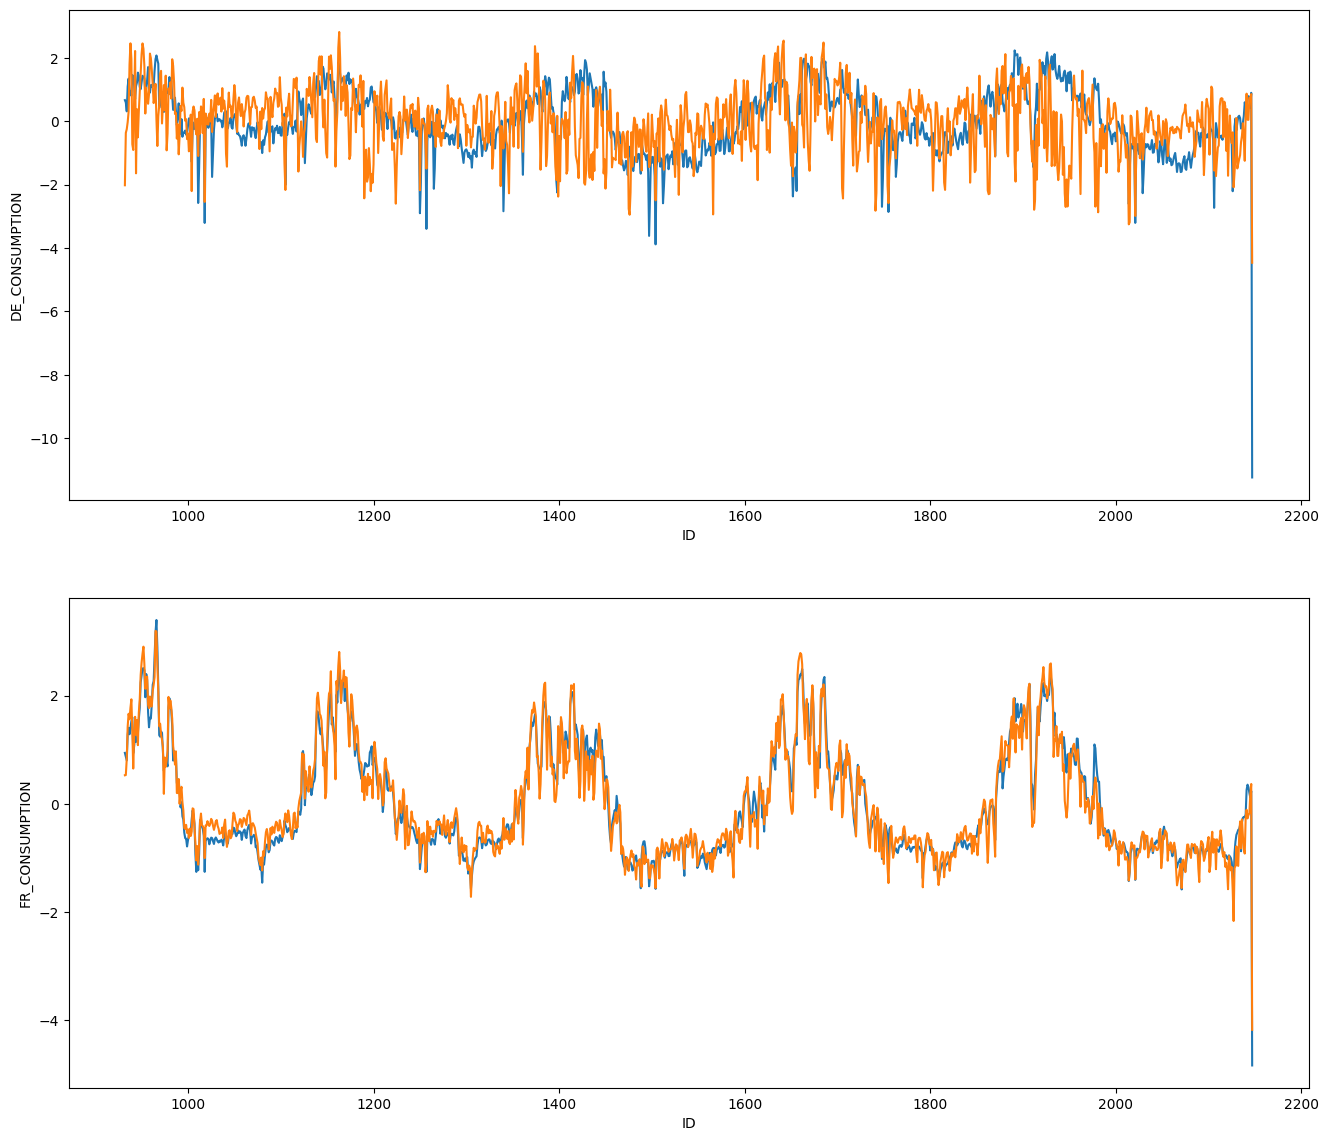

In [4]:
plt.figure()
fig, ax = plt.subplots(2, figsize=(16, 14))
sns.lineplot(x=full_fr_norm.index, y=full_fr_norm['DE_CONSUMPTION'], ax=ax[0])
sns.lineplot(x=full_fr_norm.index, y=full_fr_norm['DE_RESIDUAL_LOAD'], ax=ax[0])

sns.lineplot(x=full_fr_norm.index, y=full_fr_norm['FR_CONSUMPTION'], ax=ax[1])
sns.lineplot(x=full_fr_norm.index, y=full_fr_norm['FR_RESIDUAL_LOAD'], ax=ax[1])
plt.show()

<Axes: xlabel='ID', ylabel='FR_WINDPOW'>

<Figure size 640x480 with 0 Axes>

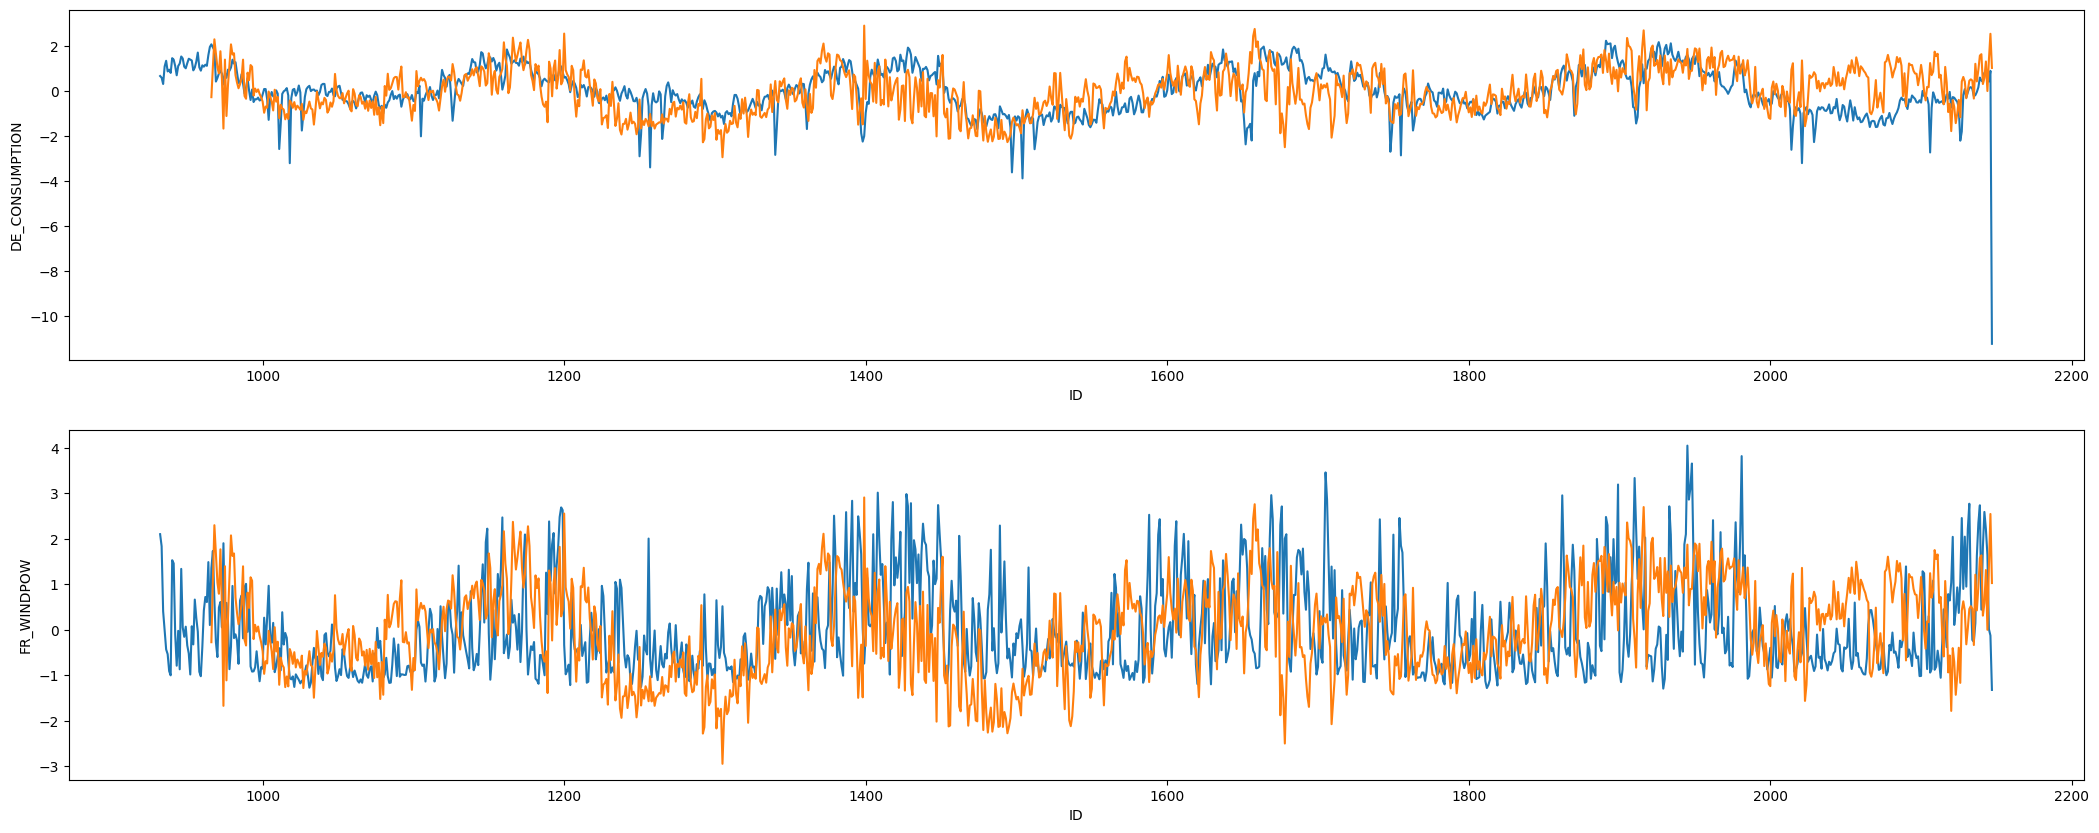

In [14]:
plt.figure()
fig, ax = plt.subplots(2, figsize=(26, 10))
sns.lineplot(x=full_fr_norm.index, y=full_fr_norm['DE_CONSUMPTION'], ax=ax[0])
sns.lineplot(x=full_fr_norm.index, y=full_fr_norm['DE_FR_EXCHANGE'], ax=ax[0])

sns.lineplot(x=full_fr_norm.index, y=full_fr_norm['FR_WINDPOW'], ax=ax[1])
sns.lineplot(x=full_fr_norm.index, y=full_fr_norm['DE_FR_EXCHANGE'], ax=ax[1])

0.9602699955365519


<Figure size 640x480 with 0 Axes>

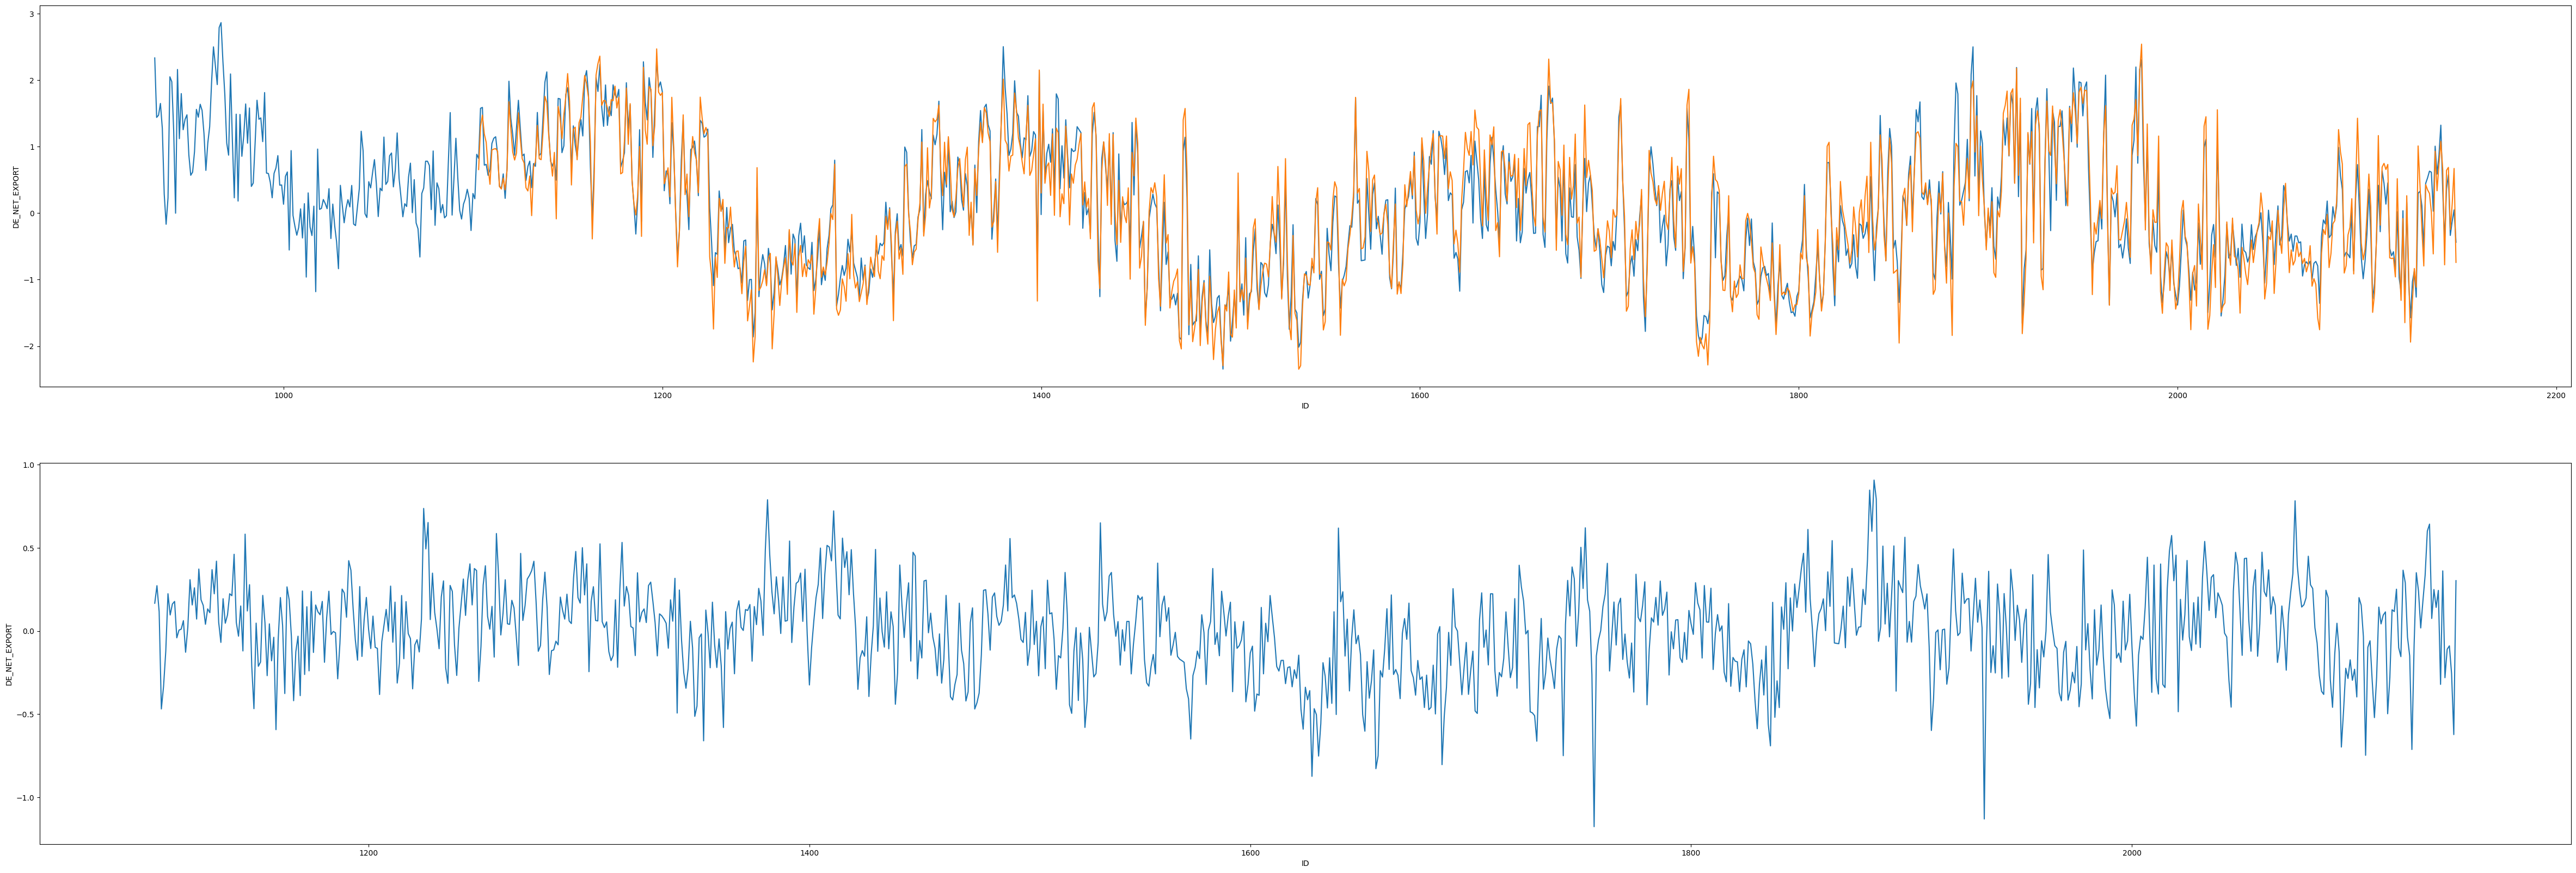

In [385]:
# regress target_col on columns, chosen by heatmap
# cols = ['DE_WINDPOW', 'FR_RESIDUAL_LOAD']
cols = full_cols
target_col = 'DE_NET_EXPORT'
ridge = linear_model.Ridge(alpha=1)
nona_idx = full_fr_norm[target_col].dropna().index[:]
exchange_train = full_fr_norm[full_fr_norm.index.isin(nona_idx)][cols]
exchange_target = full_fr_norm[full_fr_norm.index.isin(nona_idx)][target_col]
exchange_fit = full_fr_norm[cols].copy()
ridge.fit(exchange_train, exchange_target)
de_exchange_forecast = ridge.predict(exchange_fit)
plt.figure()
fig, ax = plt.subplots(2, figsize=(60, 20))
residuals = de_exchange_forecast - full_fr_norm[target_col]
sns.lineplot(x=full_fr_norm.index, y=de_exchange_forecast, ax=ax[0])
sns.lineplot(x=full_fr_norm.index, y=full_fr_norm[target_col], ax=ax[0])
sns.lineplot(x=full_fr_norm.index, y=residuals, ax=ax[1])
print(pd.Series(de_exchange_forecast, index=full_fr_norm.index)[nona_idx].corr(full_fr_norm[target_col][nona_idx]))
plt.show()

In [386]:
kf = KFold(n_splits=5, shuffle=False)
ridge = linear_model.Ridge(alpha=1)
def kf_test_ridge():
    i = 0
    cumul = 0
    for (train, test) in kf.split(exchange_train):
        i += 1
        ridge.fit(exchange_train.iloc[train], exchange_target.iloc[train])
        test_idx_convert = exchange_target.iloc[test].index
        train_idx_convert = exchange_target.iloc[train].index
        train_output = pd.Series(data=ridge.predict(exchange_train.iloc[train]), index=train_idx_convert)
        test_output = pd.Series(data=ridge.predict(exchange_train.iloc[test]), index=test_idx_convert)
        cumul += test_output.corr(exchange_target.iloc[test])
        print(f"fold {i} test corr: {test_output.corr(exchange_target.iloc[test])}")
        print(f"fold {i} train corr: {train_output.corr(exchange_target.iloc[train])}")
        print('')
    return cumul / 5
kf_test_ridge()

fold 1 test corr: 0.979872912423487
fold 1 train corr: 0.9546605358332083

fold 2 test corr: 0.9649121092210087
fold 2 train corr: 0.9594546436027844

fold 3 test corr: 0.9390257278156332
fold 3 train corr: 0.967687110424622

fold 4 test corr: 0.9461101474629311
fold 4 train corr: 0.9623432189743122

fold 5 test corr: 0.916783066782012
fold 5 train corr: 0.964801359728116



0.9493407927410142

In [388]:
pd.DataFrame(data=ridge.coef_, index=exchange_train.columns).sort_values(0, ascending=False)

,0
DE_WINDPOW,1.075585
DE_COAL,0.570374
DE_LIGNITE,0.535177
DE_SOLAR,0.351696
DE_NUCLEAR,0.339053
DE_GAS,0.297241
FR_RESIDUAL_LOAD,0.256217
FR_CONSUMPTION,0.071526
FR_WINDPOW,0.053517
DE_WIND,0.029189


0.25966853179988925

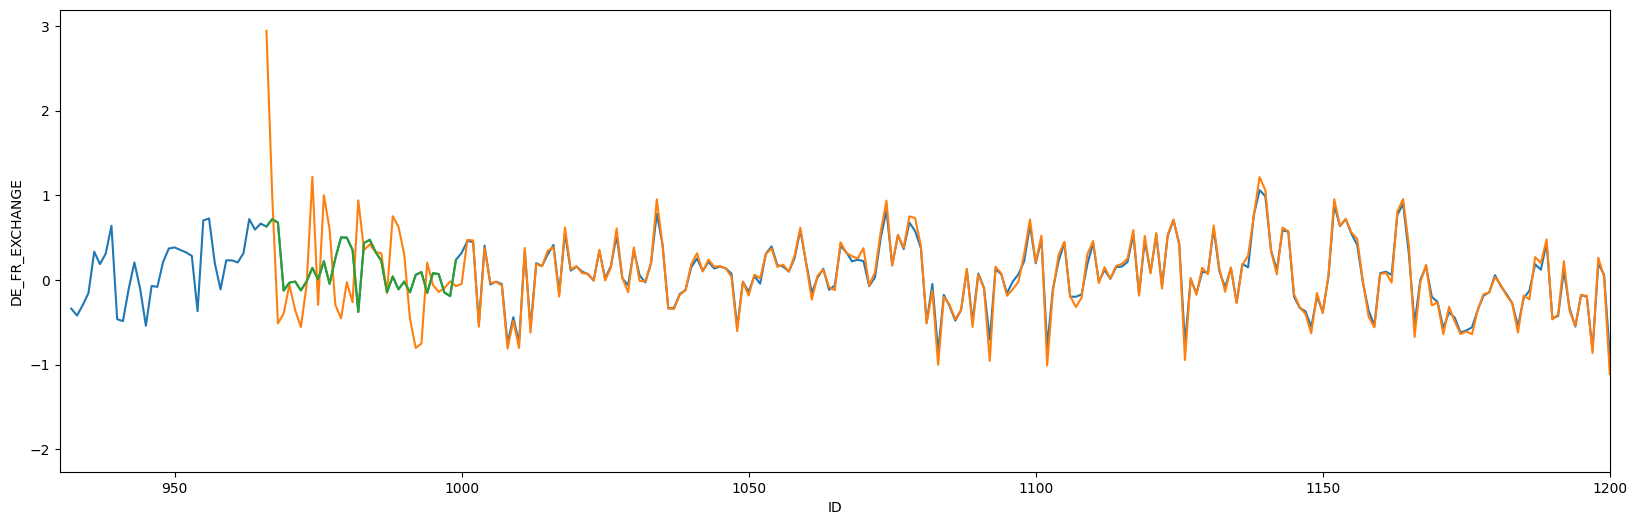

In [286]:
idx = residuals[~residuals.isna()].index
xgb_model = xgb.XGBRegressor(eta=0.3, min_child_weight=1, alpha=0.5)
x_residuals = full_fr_norm[cols].copy()
residual_train_idx = full_fr_norm[cols].loc[idx][35:235].index
residual_test_idx = full_fr_norm[cols].loc[idx][:34].index
xgb_model.fit(x_residuals.loc[residual_train_idx], residuals.loc[residual_train_idx])
residual_prediction = pd.Series(data=xgb_model.predict(x_residuals), index=full_fr_norm.index)
fig, ax = plt.subplots(figsize=(20, 6))
ax.set_xlim([930, 1200])
sns.lineplot(x=full_fr_norm.index, y=residual_prediction)
sns.lineplot(x=full_fr_norm.index, y=residuals)
sns.lineplot(x=residual_test_idx, y=residual_prediction[residual_test_idx])
residuals[residual_test_idx].corr(residual_prediction[residual_test_idx])

In [244]:
residual_prediction

array([0.9081456 , 0.9422609 , 0.38771176, ..., 0.6643706 , 0.39685184,
       0.1299218 ], dtype=float32)

In [240]:
residuals.size - residuals.count()

34

In [303]:
kf = KFold(n_splits=30, shuffle=False)
xgb_model = xgb.XGBRegressor(eta=0.2, min_child_weight=1, alpha=1)
x_residuals = full_fr_norm[cols].loc[idx]
x_residuals['ID'] = x_residuals.index
x_residuals = (x_residuals - x_residuals.mean()) / x_residuals.std()
y_residuals = residuals.loc[idx]
i = 0
for (train, test) in kf.split(x_residuals):
    i += 1
    xgb_model.fit(x_residuals.iloc[train], y_residuals.iloc[train])
    test_idx_convert = y_residuals.iloc[test].index
    train_idx_convert = y_residuals.iloc[train].index
    train_output = pd.Series(data=xgb_model.predict(x_residuals.iloc[train]), index=train_idx_convert)
    test_output = pd.Series(data=xgb_model.predict(x_residuals.iloc[test]), index=test_idx_convert)
    print(f"fold {i} test corr: {test_output.corr(y_residuals.iloc[test])}")
    print(f"fold {i} train corr: {train_output.corr(y_residuals.iloc[train])}")
    print('')

fold 1 test corr: 0.1594871431108967
fold 1 train corr: 0.9930829677376443

fold 2 test corr: -0.09589227268609478
fold 2 train corr: 0.9932606395877857

fold 3 test corr: -0.09098134636564555
fold 3 train corr: 0.9932216078768156

fold 4 test corr: -0.2257887081145768
fold 4 train corr: 0.9934024694802893

fold 5 test corr: 0.06716025149345131
fold 5 train corr: 0.9933912445898819

fold 6 test corr: -0.029104605744264964
fold 6 train corr: 0.9926351415791279

fold 7 test corr: 0.028305184083815996
fold 7 train corr: 0.9928691567038368

fold 8 test corr: 0.05124160552091233
fold 8 train corr: 0.9924387330948841

fold 9 test corr: -0.048680292859486995
fold 9 train corr: 0.9920369043315695

fold 10 test corr: -0.2705147011220432
fold 10 train corr: 0.99367846855321

fold 11 test corr: -0.13815508211937852
fold 11 train corr: 0.9932192119632391

fold 12 test corr: 0.05784948843340374
fold 12 train corr: 0.9933823522291394

fold 13 test corr: -0.031310922612894025
fold 13 train corr: 0.99

In [227]:
pd.DataFrame(data=xgb_model.feature_importances_, index=x_residuals.columns).sort_values(0, ascending=False)

,0
ID,0.188981
DE_WIND,0.067750
DE_RESIDUAL_LOAD,0.064410
DE_NUCLEAR,0.054666
FR_HYDRO,0.053767
FR_GAS,0.047914
FR_NUCLEAR,0.047800
DE_CONSUMPTION,0.047586
FR_CONSUMPTION,0.038874
DE_SOLAR,0.037411


In [102]:
pd.DataFrame(data=ridge.coef_, index=cols).sort_values(0)

,0
FR_RESIDUAL_LOAD,-1.222097
FR_WINDPOW,-0.803740
FR_NUCLEAR,-0.702468
DE_CONSUMPTION,-0.466901
FR_GAS,-0.222841
FR_HYDRO,-0.221617
FR_SOLAR,-0.140603
FR_COAL,-0.063366
DE_HYDRO,-0.031103
COAL_RET,-0.021916


In [96]:
de_exchange_forecast

array([ 4.39453125e-01,  4.68750000e-02,  4.83398438e-01, ...,
        2.01171875e-01, -3.63281250e-01, -9.84012820e+13])